# Noise (Depth 2)

author: steeve.laquitaine@epfl.ch

* The layers at depth 1 and 2 are the same in the model and in vivo.
* At depth 2, the model does not record from layer 6, while the in vivo setup does.
* Layers at Depth 2 from the model generally produce higher noise than in vivo. 

## Setup 


1. compute noise data: src/pipes/validation/noise/mpi_dense_full.py

2. activate spikeinter..

In [4]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import multiprocessing
import torch
import spikeinterface as si
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.validation import noise

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SF_V = 20000          # sampling frequency
SF_S = 20000        # sampling frequency
WIND_END = 3700             # last segment to calculate mad

# vivo ----------
# probe 1 
data_conf_hv_p1, _ = get_config("vivo_horvath", "probe_1").values() 
RAW_PATH_hv_p1 = data_conf_hv_p1["raw"]
PREP_PATH_hv_p1 = data_conf_hv_p1["preprocessing"]["output"]["trace_file_path"]
NOISE_PATH_hv_p1 = data_conf_hv_p1["analyses"]["traces"]["noise"]

# probe 2
data_conf_hv_p2, _ = get_config("vivo_horvath", "probe_2").values() 
RAW_PATH_hv_p2 = data_conf_hv_p2["raw"]
PREP_PATH_hv_p2 = data_conf_hv_p2["preprocessing"]["output"]["trace_file_path"]
NOISE_PATH_hv_p2 = data_conf_hv_p2["analyses"]["traces"]["noise"]

# probe 3
data_conf_hv_p3, _ = get_config("vivo_horvath", "probe_3").values() 
RAW_PATH_hv_p3 = data_conf_hv_p3["raw"]
PREP_PATH_hv_p3 = data_conf_hv_p3["preprocessing"]["output"]["trace_file_path"]
NOISE_PATH_hv_p3 = data_conf_hv_p3["analyses"]["traces"]["noise"]

# silico ----------
# probe 1
data_conf_hs_p1, param_conf_hs_p1 = get_config("silico_horvath", "concatenated/probe_1").values()
RAW_PATH_hs_p1 = data_conf_hs_p1["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_hs_p1 = data_conf_hs_p1["preprocessing"]["output"]["trace_file_path"]
NOISE_PATH_hs_p1 = data_conf_hs_p1["analyses"]["traces"]["noise"]

# probe 2
data_conf_hs_p2, param_conf_hs_p2 = get_config("silico_horvath", "concatenated/probe_2").values()
RAW_PATH_hs_p2 = data_conf_hs_p2["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_hs_p2 = data_conf_hs_p2["preprocessing"]["output"]["trace_file_path"]
NOISE_PATH_hs_p2 = data_conf_hs_p2["analyses"]["traces"]["noise"]

# probe 3
data_conf_hs_p3, param_conf_hs_p3 = get_config("silico_horvath", "concatenated/probe_3").values()
RAW_PATH_hs_p3 = data_conf_hs_p3["dataeng"]["campaign"]["output"]["trace_file_path"]
PREP_PATH_hs_p3 = data_conf_hs_p3["preprocessing"]["output"]["trace_file_path"]
NOISE_PATH_hs_p3 = data_conf_hs_p3["analyses"]["traces"]["noise"]

# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.4)
COLOR_HV = [0.3, 0.3, 0.3]
COLOR_HS = np.array([26, 152, 80]) / 255 # green

cl = dict()
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

2024-07-28 20:12:02,694 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-28 20:12:02,713 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-28 20:12:02,714 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-28 20:12:02,726 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-28 20:12:02,727 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-28 20:12:02,738 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-28 20:12:02,739 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-28 20:12:02,763 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-28 20:12:02,764 - root - utils.py - get_config - INFO - Reading experiment config.
2024-07-28 20:12:02,783 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-07-28 20:12:02,784 - root - utils.py - get_config 

### Specs

In [2]:
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())

available cpus: 80
available gpus: False


### (8m)Load noise data

* for 10 minutes of recording (45 mins)
* pytorch implementation (8min) of mean absolute deviation is 7 times faster than pandas (45m).

In [38]:
# load
plot_data_v2 = pd.read_csv(NOISE_PATH_hv_p2)
plot_data_s2 = pd.read_csv(NOISE_PATH_hs_p2)
# plot_data_s2 = sili_data

# select relevant data
plot_data_v1 = plot_data_v2[["noise", "layer", "experiment"]]
plot_data_s2 = plot_data_s2[["noise", "layer", "experiment"]]

# unit-test
assert plot_data_v2["layer"].unique().tolist() == [
    "L2_3",
    "L4",
    "L5",
    "L6",
], "wrong layers"
assert plot_data_s2["layer"].unique().tolist() == ["L2_3", "L4", "L5"], "wrong layers"

# stack
plot_data = pd.concat(
    [
        plot_data_v2,
        plot_data_s2,
    ],
    ignore_index=True,
)

# standardize names
plot_data["experiment"][plot_data["experiment"] == "vivo"] = "Dense probe (Horvath)"
plot_data["experiment"][
    plot_data["experiment"] == "silico"
] = "Dense probe (biophy. spont.)"

# standardize layer 2/3
plot_data["layer"][plot_data["layer"] == "L2"] = "L2/3"
plot_data["layer"][plot_data["layer"] == "L3"] = "L2/3"
plot_data["layer"][plot_data["layer"] == "L2_3"] = "L2/3"

In [39]:
def print_layer_set(exp, cfg):
    print(
        exp,
        np.unique(
            si.load_extractor(cfg["probe_wiring"]["output"]).get_property("layers")
        ),
    )

* All depth layers match except layer 6 that is captured at depth 2 in vivo.

In [40]:
print_layer_set("hv1:", data_conf_hv_p1)
print_layer_set("hs1:", data_conf_hs_p1)

print_layer_set("hv2:", data_conf_hv_p2)
print_layer_set("hs2:", data_conf_hs_p2)

print_layer_set("hv3:", data_conf_hv_p3)
print_layer_set("hs3:", data_conf_hs_p3)

hv1: ['L1' 'L2_3' 'Outside']
hs1: ['L1' 'L2_3' 'Outside']
hv2: ['L2_3' 'L4' 'L5' 'L6']
hs2: ['L2' 'L4' 'L5']
hv3: ['L6' 'Outside']
hs3: ['L6' 'Outside']


### Plot

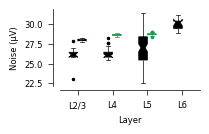

In [41]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    notch=True,
    hue_order=["Dense probe (Horvath)", "Dense probe (biophy. spont.)"],
    palette=[cl["COLOR_HV"], cl["COLOR_HS"]],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)
# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

# labels
ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_HV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (HV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (HS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1